In [1]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
import numpy as np

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-07-04 13:04:47,913 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-07-04 13:04:47,925 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-07-04 13:04:47,929 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

## Combine NDVI data with filtered GEDI data

In [4]:
gedi_recovery_2x2 = regen_analysis.process_all_fires_with_rf_control_per_burn_year(f"{DATA_PATH}/rf/burned/2x2", f"{DATA_PATH}/rf/models")

Process fires for year 1985.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1986.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1987.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1988.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1989.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1990.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1991.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1992.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1993.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1994.
matching shots within fire
Processi

In [5]:
gedi_recovery_2x2 = gedi_recovery_2x2.reset_index()

In [6]:
ndvis = np.empty((gedi_recovery_2x2.shape[0], 37))
i = 0
for year in range(1984, 2021):
    print(f"Processing year: {year}")
    raster = gedi_raster_matching.get_landsat_raster_sampler(year)
    gedi_match = gedi_raster_matching.sample_raster(raster, gedi_recovery_2x2, kernel=3)
    ndvis[:, i] = gedi_match.NDVI_mean.values
    i+=1

Processing year: 1984
Processing year: 1985
Processing year: 1986
Processing year: 1987
Processing year: 1988
Processing year: 1989
Processing year: 1990
Processing year: 1991
Processing year: 1992
Processing year: 1993
Processing year: 1994
Processing year: 1995
Processing year: 1996
Processing year: 1997
Processing year: 1998
Processing year: 1999
Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020


In [7]:
all_ndvis = np.empty((gedi_recovery_2x2.shape[0], 45))
year_of_fire = (gedi_recovery_2x2.burn_year - 1984).values.astype(int)
for i in range(gedi_recovery_2x2.shape[0]):
    for j in range(-10, 35):
        recovery_index = year_of_fire[i] + j
        if recovery_index in range(0, 36):
            all_ndvis[i, j + 10] = ndvis[i, recovery_index]
        else:
            all_ndvis[i, j + 10] = None

In [8]:
ndvis_df = pd.DataFrame(all_ndvis, columns=[str(x) for x in range(-10, 35)])
ndvis_df

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,...,25,26,27,28,29,30,31,32,33,34
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.568421,...,0.662150,0.654849,0.595411,0.644008,0.582611,0.636357,0.632610,0.675366,0.664085,0.718946
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587675,...,0.693751,0.694441,0.632157,0.694591,0.638106,0.677997,0.685623,0.718585,0.691538,0.748763
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.572759,...,0.696997,0.682389,0.627655,0.665395,0.581009,0.649598,0.642705,0.692194,0.675550,0.734887
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587906,...,0.700114,0.691291,0.643578,0.681679,0.608909,0.685482,0.681916,0.718076,0.705058,0.759061
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.506719,...,0.571775,0.589922,0.496090,0.529609,0.494940,0.538704,0.525096,0.575220,0.549411,0.628559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404823,0.423073,0.438944,0.397288,0.454312,0.442310,0.409898,0.418196,0.449566,0.434038,0.451418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404824,0.512030,0.540078,0.476451,0.525902,0.511935,0.475957,0.526999,0.561465,0.533854,0.563058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404825,0.448149,0.474085,0.430515,0.492061,0.479251,0.464917,0.479695,0.513713,0.491255,0.502332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404826,0.423473,0.427977,0.389965,0.451721,0.431205,0.427321,0.449603,0.460166,0.439250,0.462731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
gedi_ndvi = gedi_recovery_2x2.join(ndvis_df)

In [ ]:
# Save the gedi + NDVI data in a pkl file, to use for further analysis in NDVIRecovery notebook.
save_pickle("/maps/fire-regen/data/gedi_ndvi_timeseries_jun_26.pkl", gedi_ndvi)

### NDVI Recovery Statistics

Question 1: What is the median, median, std loss of NDVI per fire? Look at % and raw value. Then, look at the same but per severity.

In [4]:
# Raw value should be df[-1] - df[1]
gedi_ndvi['ndvi_fire_loss_raw'] = gedi_ndvi["-1"] - gedi_ndvi["1"]

In [5]:
gedi_ndvi['ndvi_fire_loss_rel'] = (gedi_ndvi["-1"] - gedi_ndvi["1"]) / gedi_ndvi["-1"]

<Axes: xlabel='ndvi_fire_loss_raw', ylabel='Count'>

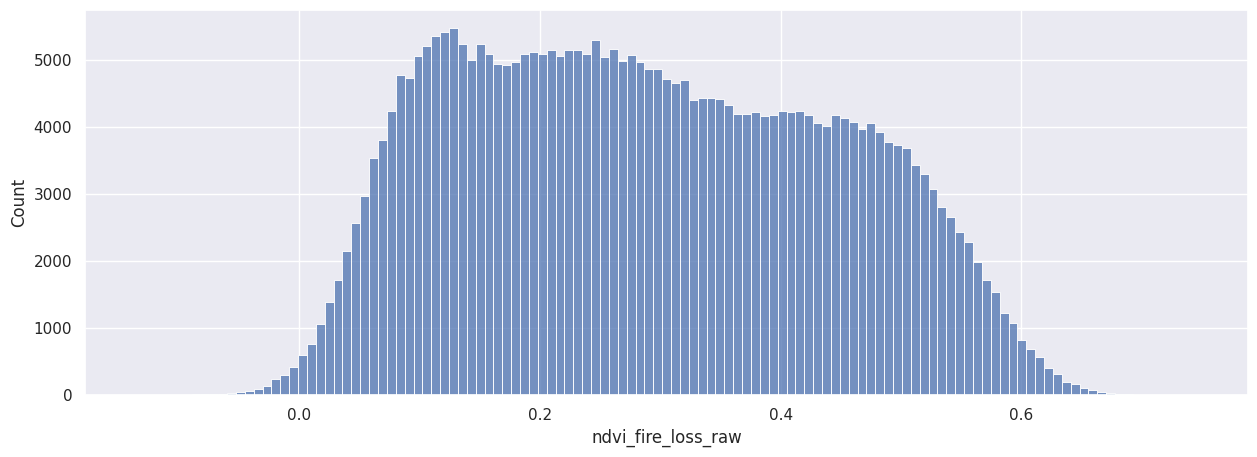

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(gedi_ndvi, x="ndvi_fire_loss_raw")

<Axes: xlabel='ndvi_fire_loss_rel', ylabel='Count'>

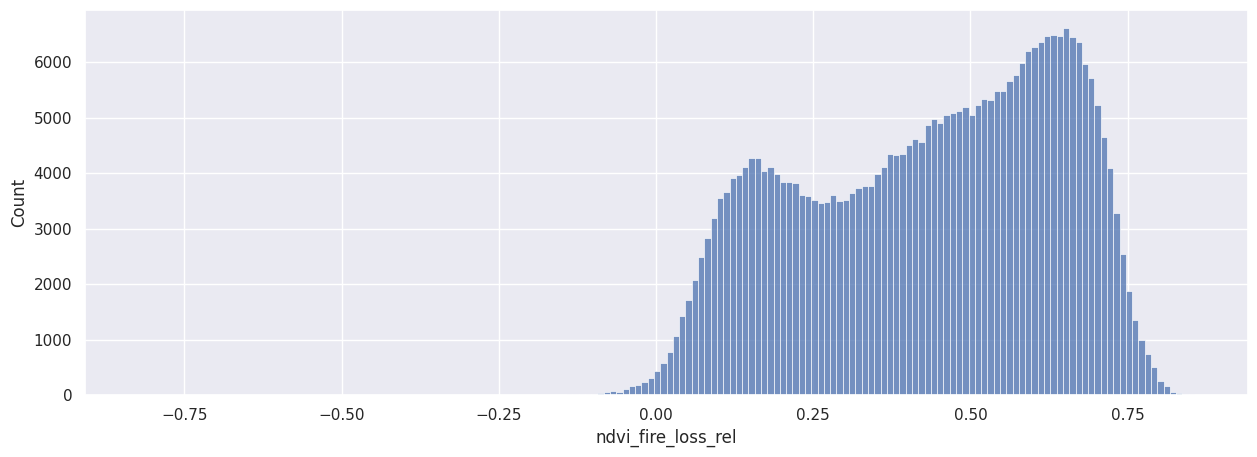

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(gedi_ndvi, x="ndvi_fire_loss_rel")

<Axes: xlabel='ndvi_fire_loss_raw', ylabel='Count'>

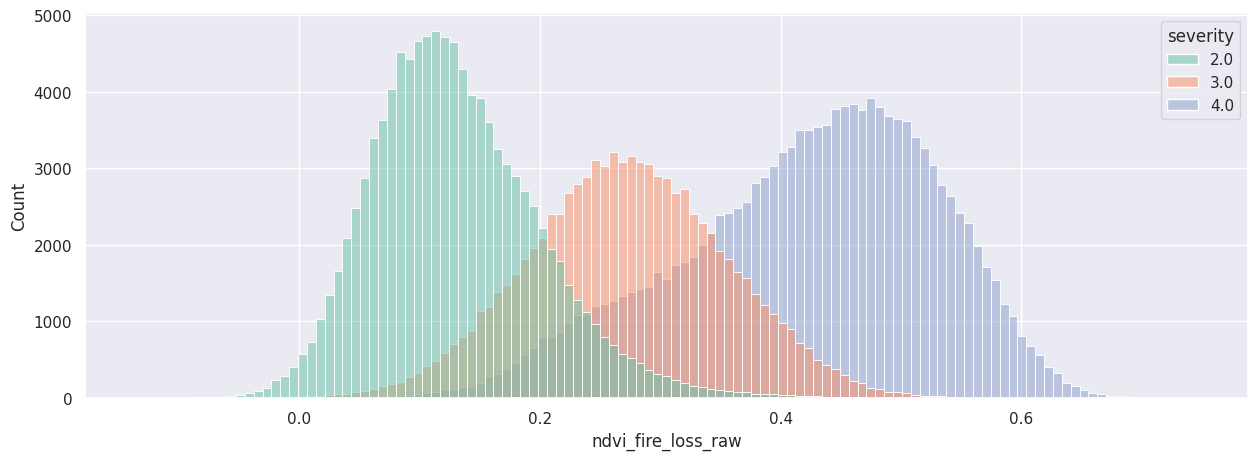

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(gedi_ndvi, x="ndvi_fire_loss_raw", hue="severity", palette="Set2")

<Axes: xlabel='ndvi_fire_loss_rel', ylabel='Count'>

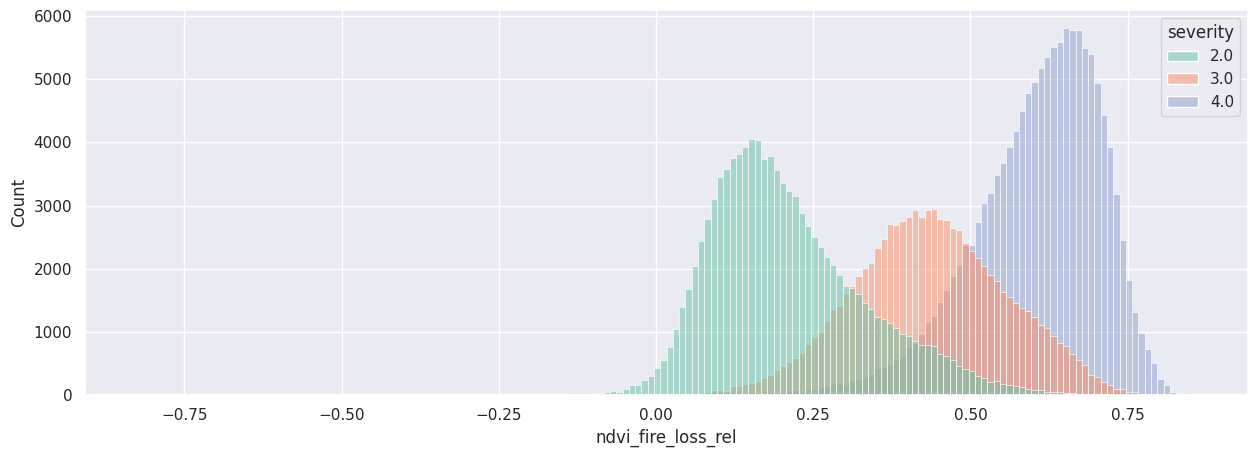

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(gedi_ndvi, x="ndvi_fire_loss_rel", hue="severity", palette="Set2")

### NDVI recovery stats

In [10]:
for i in range(1, 35):
    gedi_ndvi[f'{i}_rel'] = gedi_ndvi[f"{i}"] / gedi_ndvi["-1"]

In [11]:
print(gedi_ndvi['1_rel'].mean())
print(gedi_ndvi['5_rel'].mean())
print(gedi_ndvi['10_rel'].mean())
print(gedi_ndvi['15_rel'].mean())
print(gedi_ndvi['20_rel'].mean())
print(gedi_ndvi['25_rel'].mean())
print(gedi_ndvi['30_rel'].mean())
print(gedi_ndvi['34_rel'].mean())

0.5667907973961759
0.737331481235931
0.8483432126935685
0.8976509476723503
0.9651356829888037
1.032472549071511
1.0609927607102938
1.1345775621860472


In [12]:
gedi_ndvi.groupby("severity").mean(numeric_only=True)[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '34_rel']]

,1_rel,5_rel,10_rel,15_rel,20_rel,25_rel,30_rel,34_rel
severity,,,,,,,,
2.0,0.790435,0.855620,0.929559,0.951686,0.995331,1.032058,1.073818,1.180371
3.0,0.565790,0.743797,0.863573,0.907070,0.960872,1.023476,1.051132,1.024677
4.0,0.394935,0.658295,0.792957,0.864237,0.949962,1.037679,1.058712,1.020297


In [108]:
gedi_ndvi.groupby("severity").median(numeric_only=True)[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '34_rel']]

,1_rel,5_rel,10_rel,15_rel,20_rel,25_rel,30_rel,34_rel
severity,,,,,,,,
2.0,0.811708,0.881321,0.934634,0.965337,1.011070,1.044887,1.062997,1.169258
3.0,0.567169,0.758188,0.873850,0.929067,0.979293,1.043634,1.062986,1.059635
4.0,0.379414,0.671628,0.804425,0.877744,0.965784,1.045395,1.080521,1.046100


In [109]:
gedi_ndvi.groupby("severity").std(numeric_only=True)[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '34_rel']]

,1_rel,5_rel,10_rel,15_rel,20_rel,25_rel,30_rel,34_rel
severity,,,,,,,,
2.0,0.123247,0.129592,0.124458,0.134445,0.130742,0.162266,0.126643,0.120539
3.0,0.122235,0.158539,0.144595,0.157567,0.150818,0.164822,0.144359,0.172278
4.0,0.102853,0.185843,0.168898,0.147485,0.129543,0.137065,0.121807,0.124001


In [103]:
print(gedi_ndvi['5_rel'].median())
print(gedi_ndvi['10_rel'].median())
print(gedi_ndvi['15_rel'].median())
print(gedi_ndvi['20_rel'].median())
print(gedi_ndvi['25_rel'].median())
print(gedi_ndvi['30_rel'].median())
print(gedi_ndvi['34_rel'].median())

0.7628300822102237
0.8678192687154989
0.915036969260546
0.9807389384803745
1.0447979159169976
1.0692825929808456
1.1415032664802074
